<a href="https://colab.research.google.com/github/kinaya18/Deep-Learning/blob/main/Week-7/Seq2Seq_Tensorflowipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Muhammad Aizar Yazid / 1103223097

## Import Library

In [1]:
!pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from datasets import load_dataset
tf.keras.backend.clear_session()

## Load Dataset and Preprocessing

In [3]:
raw_dataset = load_dataset("wmt14", "de-en", split="train[:1%]")

X_raw = [ex['translation']['de'] for ex in raw_dataset if ex['translation']['de'] and ex['translation']['en']]
y_raw = [ex['translation']['en'] for ex in raw_dataset if ex['translation']['de'] and ex['translation']['en']]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/280M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/265M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/273M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/474k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/509k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4508785 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3003 [00:00<?, ? examples/s]

In [4]:
src_tokenizer = Tokenizer()
tgt_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(X_raw)
tgt_tokenizer.fit_on_texts(y_raw)

In [5]:
X_seq = src_tokenizer.texts_to_sequences(X_raw)
y_seq = tgt_tokenizer.texts_to_sequences(y_raw)

In [6]:
max_src_len = max([len(seq) for seq in X_seq])
max_tgt_len = max([len(seq) for seq in y_seq]) + 1

In [7]:
X_seq = pad_sequences(X_seq, maxlen=max_src_len, padding='post')
y_seq = pad_sequences(y_seq, maxlen=max_tgt_len, padding='post')

In [8]:
decoder_input_data = np.array([[0] + list(seq[:-1]) for seq in y_seq])
decoder_target_data = y_seq

In [9]:
X_train, X_val, dec_input_train, dec_input_val, dec_target_train, dec_target_val = train_test_split(X_seq, decoder_input_data, decoder_target_data, test_size=0.2, random_state=42)

## Sequence to Sequence Model

In [10]:
src_vocab_size = len(src_tokenizer.word_index) + 1
tgt_vocab_size = len(tgt_tokenizer.word_index) + 1

In [11]:
embedding_dim = 128
latent_dim = 256

In [12]:
encoder_inputs = Input(shape=(max_src_len,))
enc_emb = Embedding(src_vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
encoder_lstm, state_h, state_c = LSTM(latent_dim, return_state=True, use_bias=False, recurrent_initializer='glorot_uniform')(enc_emb)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(max_tgt_len,))
dec_emb = Embedding(tgt_vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=False, use_bias=False, recurrent_initializer='glorot_uniform', recurrent_activation='sigmoid')(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(tgt_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_lstm)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

## Model Training

In [13]:
history = model.fit(
    [X_train, dec_input_train],
    np.expand_dims(dec_target_train, -1),
    batch_size=32,
    epochs=20,
    validation_data=([X_val, dec_input_val], np.expand_dims(dec_target_val, -1)),
    verbose=1
)

Epoch 1/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 187s 158ms/step - accuracy: 0.3340 - loss: 6.6266 - val_accuracy: 0.1699 - val_loss: 5.4536
Epoch 2/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 196s 158ms/step - accuracy: 0.0979 - loss: 5.2910 - val_accuracy: 0.0453 - val_loss: 5.1505
Epoch 3/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 202s 158ms/step - accuracy: 0.2105 - loss: 4.9293 - val_accuracy: 0.0350 - val_loss: 4.9405
Epoch 4/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 202s 158ms/step - accuracy: 0.4344 - loss: 4.6607 - val_accuracy: 0.6864 - val_loss: 4.8152
Epoch 5/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 202s 158ms/step - accuracy: 0.3688 - loss: 4.4552 - val_accuracy: 0.2407 - val_loss: 4.7411
Epoch 6/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 192s 150ms/step - accuracy: 0.1878 - loss: 4.2706 - val_accuracy: 0.1810 - val_loss: 4.6935
Epoch 7/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 211s 158ms/step - accuracy: 0.2808 - loss: 4.1213 - val_accuracy: 0.2090 - val_loss: 4.6692
Epoch 8/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 202s 158ms/step - ac

## Model Visualization

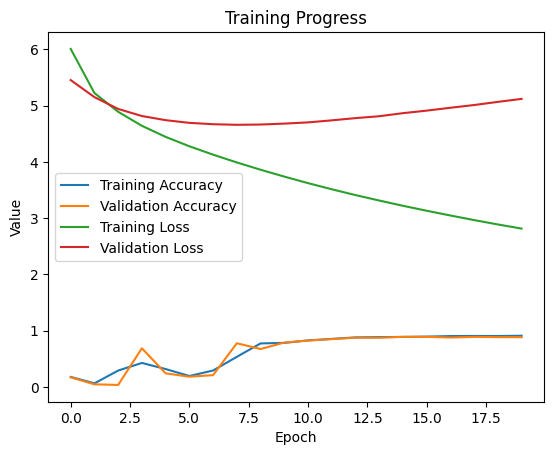

In [14]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()